# Load Libraries

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import gensim  # para cargar modelo w2v
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model
import nltk
from nltk.corpus import stopwords
import contractions

2025-05-06 09:24:12.443305: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [2]:
#Load Stop Words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ola/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#Read Data
data = pd.read_csv("deceptive-opinion.csv", usecols=['polarity','text'])
data.head(10)

,polarity,text
0,positive,We stayed for a one night getaway with family ...
1,positive,Triple A rate with upgrade to view room was le...
2,positive,This comes a little late as I'm finally catchi...
3,positive,The Omni Chicago really delivers on all fronts...
4,positive,I asked for a high floor away from the elevato...
5,positive,I stayed at the Omni for one night following a...
6,positive,We stayed in the Conrad for 4 nights just befo...
7,positive,Just got back from 2 days up in Chicago shoppi...
8,positive,We arrived at the Omni on 2nd September for a ...
9,positive,"On our visit to Chicago, we chose the Hyatt du..."


# Data Preprocessing

In [4]:

# Function to remove punctuation and numbers
def remove_puntuacion(text):
  """Remove puntuación and numbers"""
  new_text = re.sub('[^a-z]+', ' ', text)  
  return new_text  
# Function to remove Stop words
def remove_stopwords(text):
   """Remove Stopwords"""
   stop = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
   new_text= stop.sub('', text)
   return new_text 

def preprocesar(text):
  text= contractions.fix(text)
  text = text.lower()
  text = remove_stopwords(text)
  text = remove_puntuacion(text)
  return(text)

In [6]:
# Convert text to lower case and remove punctuation
data['text_pp'] = data['text'].apply(preprocesar)
# Get lenght of each text review
data['text_pp_len'] = data['text_pp'].str.split().str.len()
data['text_len'] = data['text'].str.split().str.len()
data.head(10)
     

,polarity,text,text_pp,text_pp_len,text_len
0,positive,We stayed for a one night getaway with family ...,stayed one night getaway family thursday tripl...,58,105
1,positive,Triple A rate with upgrade to view room was le...,triple rate upgrade view room less also includ...,30,45
2,positive,This comes a little late as I'm finally catchi...,comes little late finally catching reviews pas...,104,207
3,positive,The Omni Chicago really delivers on all fronts...,omni chicago really delivers fronts spaciousne...,63,127
4,positive,I asked for a high floor away from the elevato...,asked high floor away elevator got room pleasa...,33,72
5,positive,I stayed at the Omni for one night following a...,stayed omni one night following business meeti...,92,183
6,positive,We stayed in the Conrad for 4 nights just befo...,stayed conrad nights thanksgiving corner room ...,59,118
7,positive,Just got back from 2 days up in Chicago shoppi...,got back days chicago shopping girlfriends fir...,68,131
8,positive,We arrived at the Omni on 2nd September for a ...,arrived omni nd september day stay took ill le...,78,164
9,positive,"On our visit to Chicago, we chose the Hyatt du...",visit chicago chose hyatt due location downtow...,49,86


In [8]:
# Get Vocabulary from hotel reviews
def vocabulary(pandas_series):
    word_list = " ".join(sec for sec in pandas_series).split(" ")
    x = Counter(word_list)

    return [i for i,_ in x.most_common() ]

vocabulary_words = vocabulary(data['text_pp'])
vocabulary_words

['hotel',
 'room',
 '',
 'chicago',
 'stay',
 'would',
 'great',
 'staff',
 'service',
 'one',
 'rooms',
 'stayed',
 'us',
 'could',
 'night',
 'like',
 'get',
 'time',
 'desk',
 'nice',
 'location',
 'even',
 'bed',
 'also',
 'clean',
 'good',
 'got',
 'front',
 'back',
 'check',
 'well',
 'place',
 'first',
 'day',
 'bathroom',
 'experience',
 'next',
 'two',
 'really',
 'friendly',
 'comfortable',
 'never',
 'made',
 'hotels',
 'go',
 'recommend',
 'business',
 'lobby',
 'view',
 'staying',
 'much',
 'city',
 'floor',
 'better',
 'area',
 'food',
 'went',
 'breakfast',
 'called',
 'price',
 'best',
 'arrived',
 'definitely',
 'say',
 'restaurant',
 'bar',
 'weekend',
 'everything',
 'told',
 'helpful',
 'found',
 'small',
 'free',
 'trip',
 'make',
 'booked',
 'downtown',
 'right',
 'way',
 'another',
 'asked',
 'beds',
 'beautiful',
 'took',
 'husband',
 'minutes',
 'ever',
 'many',
 'away',
 'people',
 'door',
 'water',
 'reservation',
 'hilton',
 'nights',
 'wonderful',
 'morning

In [9]:
# Count vocabulary  Unique words
len(vocabulary_words)

9133

In [8]:
#Map words to tokens and numeric values


def get_dict_map(token_or_tag):
    if token_or_tag == 'token':
        # agregamos 'PAD_token' al vocabulario de tokens, para ser usado más
        # adelante a fin de que todas las oraciones tengan la misma cantidad de
        # tokens
        vocab = ['PAD_token'] + [token for token in vocabulary(data['text_pp']) if token is not None] 
    elif token_or_tag == 'tag':
        vocab = vocabulary(data['Tags'])

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map('token')
print(token2idx['PAD_token'])
print(len(token2idx))   


0
9164


In [ ]:
# Map tokes to numeric values
data['tokens'] = data['text_pp'].str.split()

<Axes: >

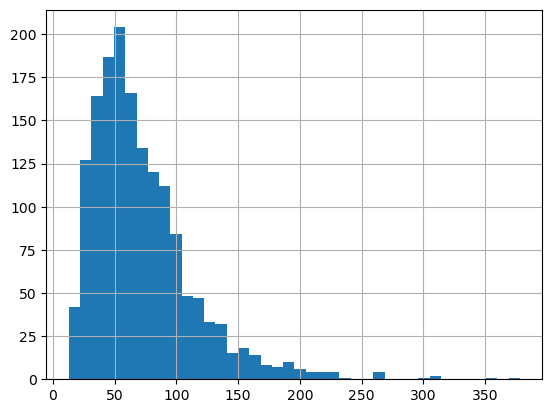

In [10]:
#Histogram with reviews lenght
data['text_len'].hist(bins=40) 

In [11]:
# Estimate percentiles for the variable text_len
custom_percentiles = list(range(5, 101,5))
custom_percentile_values = np.percentile(data['text_len'], custom_percentiles)
percentile_table = pd.DataFrame({
    'Percentile': custom_percentiles,
    'Value': custom_percentile_values
})
print(percentile_table)

    Percentile   Value
0            5   25.95
1           10   31.00
2           15   36.00
3           20   40.00
4           25   44.00
5           30   48.00
6           35   51.00
7           40   54.00
8           45   58.00
9           50   62.00
10          55   67.00
11          60   72.00
12          65   77.00
13          70   83.00
14          75   90.00
15          80   97.00
16          85  107.00
17          90  124.00
18          95  151.05
19         100  378.00


In [39]:
# Define max lenght for reviews
max_len = int(data['text_len'].quantile(0.99))
max_len

216

In [40]:
#View Data
data.head(10)

,polarity,text,text_p,text_pp,text_len,text_idx
0,positive,we stayed for a one night getaway with family ...,we stayed for a one night getaway with family ...,stayed one night getaway family thursday tripl...,57,"[12, 10, 13, 564, 147, 1733, 2652, 1894, 185, ..."
1,positive,triple a rate with upgrade to view room was le...,triple a rate with upgrade to view room was le...,triple rate upgrade view room less also includ...,30,"[2652, 185, 478, 49, 2, 303, 24, 497, 58, 2654..."
2,positive,this comes a little late as i'm finally catchi...,this comes a little late as i m finally catchi...,comes little late finally catching reviews pas...,104,"[951, 125, 279, 105, 3762, 225, 480, 209, 905,..."
3,positive,the omni chicago really delivers on all fronts...,the omni chicago really delivers on all fronts...,omni chicago really delivers fronts spaciousne...,63,"[219, 4, 39, 3110, 3764, 5018, 11, 70, 8, 5019..."
4,positive,i asked for a high floor away from the elevato...,i asked for a high floor away from the elevato...,asked high floor away elevator got room pleasa...,33,"[81, 132, 53, 89, 343, 27, 2, 1110, 460, 2655,..."
5,positive,i stayed at the omni for one night following a...,i stayed at the omni for one night following a...,stayed omni one night following business meeti...,92,"[12, 219, 10, 13, 1176, 47, 413, 79, 77, 4, 1,..."
6,positive,we stayed in the conrad for 4 nights just befo...,we stayed in the conrad for nights just before...,stayed conrad nights thanksgiving corner room ...,59,"[12, 244, 95, 2657, 385, 2, 1424, 1736, 106, 3..."
7,positive,just got back from 2 days up in chicago shoppi...,just got back from days up in chicago shopping...,got back days chicago shopping girlfriends fir...,68,"[27, 29, 174, 4, 120, 1904, 33, 17, 12, 219, 3..."
8,positive,we arrived at the omni on 2nd september for a ...,we arrived at the omni on nd september for a d...,arrived omni nd september day stay took ill le...,77,"[62, 219, 849, 1114, 34, 5, 84, 1616, 131, 312..."
9,positive,"on our visit to chicago, we chose the hyatt du...",on our visit to chicago we chose the hyatt due...,visit chicago chose hyatt due location downtow...,49,"[122, 4, 500, 236, 468, 20, 77, 260, 170, 242,..."


In [41]:
# Check for None values within column text_idx
print("\nConcise check for None within lists in data['text_idx']:")
has_none = False
for index, text_indices in data['text_idx'].items():
    if isinstance(text_indices, list) and any(value is None for value in text_indices):
        print(f"List at DataFrame index {index} contains None values.")
        print(data.loc[index]['text_pp'])
        has_none = True
    elif text_indices is None:
        print(f"The entire entry at DataFrame index {index} is None")
        has_none = True

if not has_none:
    print("\nNo None values found within the lists in data['text_idx'].")


Concise check for None within lists in data['text_idx']:

No None values found within the lists in data['text_idx'].


In [42]:
# Padding, add Pad Token to make reviews of the same length
pad_tokens = pad_sequences(data['text_idx'], maxlen= max_len,
                           dtype='int32', padding='post',
                           value = token2idx['PAD_token'])

In [43]:
pad_tokens[1]

array([2652,  185,  478,   49,    2,  303,   24,  497,   58, 2654,    7,
         49,  310,  369, 2354, 3761, 1896, 3761,  659,  179,  120, 1172,
        479,  260,  170,  242,  146,    2,   41,   22,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

# Use trained Word2Vec to map words into vectors
 Code is commented after saving pikle object with the word embeddings present in the vocabulary of the hotel reviews.

In [44]:
# Load Word2Vec
#file =  '/home/ola/Documents/ubuntu/mydsportafolio/rnn_classifier/notes/GoogleNews-vectors-negative300.bin.gz'
#w2v = gensim.models.KeyedVectors.load_word2vec_format(file,  binary=True)


In [45]:
#Explore word2vec
#print('Words in model w2v: {:,} '.format(len(w2v.key_to_index)))
#print('Dimensions for embedding: ', w2v.vector_size)   
#Words in model w2v: 3,000,000 
#Dimensions for embedding:  300


# Save embeddings from word2vec present in the hotel reviews

In [46]:
# Create Dictionary with embeddings
#dic_tokens_word2vec  = {}
#words_no_embedding =[]
#for token in vocabulary_words:
#   try:
#     dic_tokens_word2vec[token] = w2v[token]
#   except:
#     words_no_embedding.append(token)

In [47]:
#print(f'Words in model w2v:{len(vocabulary_words)}')
#print(f'Words without embedding:{len(words_no_embedding)}')
#Words in model w2v:9309
#Words without embedding:543

In [48]:
# Save embeddings into pickle object
#import pickle
#path = '/home/ola/Documents/ubuntu/mydsportafolio/rnn_classifier/notes/Pikles'
#pickle.dump(dic_tokens_word2vec, open (path + "dic_tokens_hotel_w2v.pkl", 'wb'))

# Load embeddings from word2vec present in the hotel reviews

In [49]:
import pickle
path = '/home/ola/Documents/ubuntu/mydsportafolio/rnn_classifier/notes/Pikles'
dic_tokens_word2vec = pickle.load(open(path + "dic_tokens_hotel_w2v.pkl", 'rb'))
words_no_embedding = [tok for tok in vocabulary_words if tok not in dic_tokens_word2vec.keys()]

In [50]:
#Get Embeddings Matrix
num_tokens = len(token2idx)
print(num_tokens)
embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for token, i in token2idx.items():
    if token in dic_tokens_word2vec.keys():
       embedding_matrix[i] = dic_tokens_word2vec[token]

9164


In [51]:
pd.DataFrame(embedding_matrix)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.026123,0.014404,-0.034424,-0.005829,0.026978,0.051514,-0.123047,-0.289062,0.339844,-0.027100,...,-0.053955,0.096191,0.138672,0.194336,0.108398,-0.191406,-0.131836,0.156250,0.099609,0.126953
2,0.026245,0.132812,-0.023438,0.091309,0.018066,0.039062,-0.039307,-0.086914,0.195312,-0.036377,...,-0.169922,0.073242,0.048340,0.024292,-0.038818,-0.445312,-0.078613,0.121582,-0.132812,0.103027
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.134766,0.181641,0.093262,0.414062,-0.130859,0.294922,-0.378906,-0.211914,0.051025,0.036133,...,0.080566,0.294922,-0.057861,0.134766,0.058838,-0.187500,-0.176758,-0.441406,-0.007812,0.006744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9159,-0.036865,0.205078,0.086914,-0.051758,0.067871,0.092285,-0.027466,0.390625,0.474609,0.259766,...,0.054932,0.023071,0.182617,0.154297,-0.263672,0.285156,-0.228516,0.061523,-0.026978,0.204102
9160,0.001266,0.014221,-0.071777,-0.248047,-0.314453,0.054932,0.189453,-0.139648,0.417969,0.259766,...,0.193359,0.168945,-0.024536,-0.034180,-0.090820,-0.361328,0.335938,-0.019287,0.123535,0.005188
9161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9162,0.082031,0.250000,-0.070312,0.108887,-0.130859,0.026855,-0.009705,-0.035156,-0.125977,-0.238281,...,0.100586,-0.249023,0.123047,-0.016235,-0.175781,-0.091309,-0.128906,-0.036865,-0.078613,0.161133


# Split Data in training and testing

In [52]:
#data['polarity'] = np.where(data['polarity']=='positive', 1, 0)
#data['polarity'].value_counts()
y =  pd.get_dummies(data['polarity'], drop_first=True).values
y

array([[ True],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [53]:

train_tokens, test_tokens, train_y, test_y = train_test_split(
pad_tokens, y, test_size=0.2, train_size=0.8, random_state=2020)

print(
f'''train_tokens: {len(train_tokens)}
train_y: {len(train_y)}


test_tokens: {len(test_tokens)}
test_y: {len(test_y)}'''
)

print(train_tokens.shape,train_y.shape)
print(test_tokens.shape,test_y.shape)


train_tokens: 1280
train_y: 1280


test_tokens: 320
test_y: 320
(1280, 216) (1280, 1)
(320, 216) (320, 1)


In [54]:
print(y)

[[ True]
 [ True]
 [ True]
 ...
 [False]
 [False]
 [False]]


# Building neural network

In [55]:
num_tokens

9164

In [56]:
# Build RNN
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
input = Input(shape = (max_len,))

# Capa de Embedding
embedding = Embedding(input_dim = num_tokens,
                      output_dim = 300,
                      weights = [embedding_matrix],
                      #embeddings_initializer = Constant(embedding_matrix),
                      input_length= max_len,
                      trainable=False)(input)
# Capa 1 LSTM 
LSTM_layer = LSTM(units=128,
                    recurrent_dropout=0.2, dropout=0.2  # Para evitar sobreajuste
                    )(embedding)
# Capa de Salida
n_output_class = 1
out =  Dense(n_output_class,     # dimensiones de salida (2 clases)
          activation="softmax"  # para obtener una probabilidad para cada clase
                                # función de activación
                                # https://www.tensorflow.org/api_docs/python/tf/keras/activations
          )(LSTM_layer)



/home/ola/miniconda3/envs/my_rnn/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [57]:
input

<KerasTensor shape=(None, 216), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5>

In [58]:
out

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_8>

In [59]:
numpy_result = input + out
numpy_result 

<KerasTensor shape=(None, 216), dtype=float32, sparse=False, ragged=False, name=keras_tensor_9>

In [60]:
RNN_model = Model(input, out)  # unión del modelo
RNN_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 216)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 216, 300)       │     2,749,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,968,977 (11.33 MB)

 Trainable params: 219,777 (858.50 KB)

 Non-trainable params: 2,749,200 (10.49 MB)

In [61]:
plot_model(
    RNN_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


# Model training

In [62]:
# Compile model
RNN_model.compile(optimizer='adam',         # el optimizador sirve para encontrar los pesos que minimizan la función de pérdida
                                            # adam: stochastic gradient descent adaptativo
                                            # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
                  loss="binary_crossentropy", # función que evalua que tan bien el algoritmo modela el conjunto de datos
                                                   # https://www.tensorflow.org/api_docs/python/tf/keras/losses
                  metrics=['accuracy'])

In [63]:
history = RNN_model.fit(train_tokens, train_y,                        
                        validation_split=0.2,
                        batch_size=100,
                        epochs=5,   # número de iteraciones sobre los datos
                        verbose=1)

Epoch 1/5


/home/ola/miniconda3/envs/my_rnn/lib/python3.12/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 423ms/step - accuracy: 0.4847 - loss: 0.6932 - val_accuracy: 0.5078 - val_loss: 0.6923
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 406ms/step - accuracy: 0.4847 - loss: 0.6903 - val_accuracy: 0.5078 - val_loss: 0.6923
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 479ms/step - accuracy: 0.4847 - loss: 0.6904 - val_accuracy: 0.5078 - val_loss: 0.6893
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 439ms/step - accuracy: 0.4847 - loss: 0.6893 - val_accuracy: 0.5078 - val_loss: 0.6903
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 479ms/step - accuracy: 0.4847 - loss: 0.6882 - val_accuracy: 0.5078 - val_loss: 0.6896


In [64]:
test_pred = RNN_model.predict(np.array(test_tokens), verbose=1)

true = 0
for i, y in enumerate(test_y):
    if y == test_pred[i]:
        true += 1

print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(test_y) - true))
print('Accuracy: {}'.format(true/len(test_y)*100))

 1/10 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step

/home/ola/miniconda3/envs/my_rnn/lib/python3.12/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Correct Prediction: 166
Wrong Prediction: 154
Accuracy: 51.87500000000001
